# Interpreting BERT Models (Part 1)

In this notebook we demonstrate how to interpret Bert models using  `Captum` library. In this particular case study we focus on a fine-tuned Question Answering model on SQUAD dataset using transformers library from Hugging Face: https://huggingface.co/transformers/

We show how to use interpretation hooks to examine and better understand embedding, bert, and attention layers. 

Note: Before running this tutorial, please install the seaborn and matplotlib python packages.

In [524]:
import os
import sys

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [523]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The first step is to fine tune BERT model on SQUAD dataset. This can be easiy accomplished by following the steps described in hugging face's official web site: https://github.com/huggingface/transformers#run_squadpy-fine-tuning-on-squad-for-question-answering 

After we pretrained the model, we can loading the tokenizer and pre-trained BERT model using commands described below. 

In [525]:
model_path = '/home/narine/debug_squad' # <PATH-TO-SAVED-MODEL>

# load model
model = BertForQuestionAnswering.from_pretrained(model_path) #, output_attentions=True)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

In [475]:
torch.manual_seed(0)

A helper function to perform forward pass of the model and accomplish predictions

In [520]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    return model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )

Defining a custom forward function that will allow us to access the start and end postitions of our prediction using `position` input argument.

In [522]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

Let's interpret parent `BertEmbeddings` layer. For that reason we separate embedding layer and precompute the embeddings. `configure_interpretable_embedding_layer` function helps us to do that. It returns `InterpretableEmbeddingBase` layer that wraps `BertEmbeddings` and can be used to access the embedding vectors. Note that we need to remove `InterpretableEmbeddingBase` wrapper from our model using `remove_interpretable_embedding_layer` function after we finish interpretation.

Note that there is a way to interpret BertEmbeddings without configuring interpretable embedding layers that we will make available soon, However it is important to not that configuring interpretable embedding layers gives us more flexibility.

In [477]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings')


/home/narine/captum/captum/attr/_models/base.py:181: UserWarning: In order to make embedding layers more interpretable they will
        be replaced with an interpretable embedding layer which wraps the
        original embedding layer and takes word embedding vectors as inputs of
        the forward function. This allows to generate baselines for word
        embeddings and compute attributions for each embedding dimension.
        The original embedding layer must be set
        back by calling `remove_interpretable_embedding_layer` function
        after model interpretation is finished.
  after model interpretation is finished."""


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): InterpretableEmbeddingBase(
      (embedding): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   

Defining and numericalizing / encoding special tokens

In [527]:
ref = "[PAD]" # A token used for generating token reference
sep = "[SEP]" # A token used as a separator between question and text and it is also added to the end of the text.
cls = "[CLS]" # This token is prepended to the concatenated question-text word sequence

ref_token_id = tokenizer.encode(ref)
sep_token_id = tokenizer.encode(sep)
cls_token_id = tokenizer.encode(cls)

Below we define a set of helper function fo constructing refenreces / baselines for word tokens, token types and position ids.

In [1]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question)
    text_ids = tokenizer.encode(text)

    # construct input token ids
    input_ids = cls_token_id + question_ids + sep_token_id + text_ids + sep_token_id

    # construct reference token ids 
    ref_input_ids = cls_token_id + ref_token_id * len(question_ids) + sep_token_id + \
        ref_token_id * len(text_ids) + sep_token_id

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    input_ids_ = input_ids[0]
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(len(input_ids_))]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    ref_position_ids = position_ids[torch.randperm(seq_length, device=device)]
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_sub_bert_embedding(input_ids, ref_input_ids,
                                   token_type_ids, ref_token_type_ids,
                                   position_ids, ref_position_ids):
    input_embeddings = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding1.indices_to_embeddings(ref_input_ids)

    input_embeddings_token_type = interpretable_embedding2.indices_to_embeddings(token_type_ids)
    ref_input_embeddings_token_type = interpretable_embedding2.indices_to_embeddings(ref_token_type_ids)

    input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(position_ids)
    ref_input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(ref_position_ids)
    
    return (input_embeddings, ref_input_embeddings), \
           (input_embeddings_token_type, ref_input_embeddings_token_type), \
           (input_embeddings_position_ids, ref_input_embeddings_position_ids)
    
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    
    return input_embeddings, ref_input_embeddings


Let's define the `question - text` pair that we'd like to use as an input for our Bert model and interpret what the model was forcusing on when predicting an answer to the question from given input text 

In [482]:
#question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
#question, text = "How old is Jim Henson?", "Jim Henson is 24 years old"

#question, text = "How many artworks did Van Gogh create?", \
#                 "In just over a decade Vincent van Gogh created about 2,100 artworks, " \
#                 "including around 860 oil paintings, most of which date from the last two years of his life."

question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."
#question, text = "Who is most likely to teach a child at home?", "In some countries, formal education can take place through home schooling. Informal learning may be assisted by a teacher occupying a transient or ongoing role, such as a family member, or by anyone with knowledge or skills in the wider community setting."


Let's numericalize the question, the input text and generate corresponding references

In [483]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)
print(input_ids.dtype, input_ids)
print(token_type_ids, ref_token_type_ids)
print(position_ids, ref_position_ids)



torch.int64 tensor([[ 101, 1184, 1110, 1696, 1106, 1366,  136,  102, 1122, 1110, 1696, 1106,
         1366, 1106, 1511,  117, 9712, 9447, 1105, 1619, 3612, 1104, 1155, 7553,
          119,  102]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0') tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0')
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25]], device='cuda:0') tensor([[25, 23,  5,  3,  8, 20,  0,  1, 10, 12, 22,  6, 21, 11, 13,  7,  2, 14,
         19, 16, 17, 18,  4, 24, 15,  9]], device='cuda:0')


Now let's comput the embedding vectors for BertEmbedding and make predictions using those embeddings both for the input and reference

In [484]:
input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

start_scores, end_scores = predict(input_embeddings, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)

ref_start_scores, ref_end_scores = predict(ref_input_embeddings, \
                                           token_type_ids=ref_token_type_ids, \
                                           position_ids=ref_position_ids, \
                                           attention_mask=attention_mask)

all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().tolist()) 
print(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
print(' '.join(all_tokens[torch.argmax(ref_start_scores) : torch.argmax(ref_end_scores)+1]))
print(input_embeddings, ref_input_embeddings)
#print(attn[0].shape)

to include , em ##power and support humans of all kinds
it is important to us to include , em ##power and support humans of all kinds .
tensor([[[ 0.4368,  0.0743, -0.2138,  ...,  0.0359,  0.0735, -0.1483],
         [-0.7860, -1.1014,  0.0221,  ..., -0.4431, -0.5254,  0.4514],
         [-1.1792,  0.2095,  0.6804,  ...,  0.5314,  1.1256,  0.7433],
         ...,
         [ 0.0305, -0.0719, -0.5761,  ..., -1.1417, -1.6071,  1.0821],
         [-0.2231,  0.3109,  1.0365,  ...,  0.1760,  0.3919,  0.3608],
         [-0.0254, -0.5551,  0.4981,  ...,  0.4892, -0.6702,  0.6614]]],
       device='cuda:0', grad_fn=<AddcmulBackward>) tensor([[[ 0.4368,  0.0743, -0.2138,  ...,  0.0359,  0.0735, -0.1483],
         [-0.4586, -0.8524,  0.3253,  ...,  0.3703, -0.4630,  0.4020],
         [-0.1351, -0.9157,  0.5216,  ...,  0.3649, -0.5518,  0.2779],
         ...,
         [ 0.6944, -1.3654,  0.6246,  ...,  0.2864, -0.3174,  0.8840],
         [ 0.5152, -1.0316,  0.5615,  ...,  0.3071, -0.4280,  0.5677],
  

In [485]:
#squad_pos_forward_func(input_embeddings, token_type_ids, position_ids, attention_mask)
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    #attributions = attributions.cpu().detach().numpy()
    return attributions


In [486]:
text = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy())
print(text, ' '.join(text))


['[CLS]', 'what', 'is', 'important', 'to', 'us', '?', '[SEP]', 'it', 'is', 'important', 'to', 'us', 'to', 'include', ',', 'em', '##power', 'and', 'support', 'humans', 'of', 'all', 'kinds', '.', '[SEP]'] [CLS] what is important to us ? [SEP] it is important to us to include , em ##power and support humans of all kinds . [SEP]


In [487]:
ig = IntegratedGradients(squad_pos_forward_func)

#nt = NoiseTunnel(ig)

print('squad_pos_forward_func: ', squad_pos_forward_func(input_embeddings, token_type_ids, attention_mask=attention_mask))
model.zero_grad()
attributions_start = ig.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 0))
attributions_end = ig.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids, attention_mask, 1))
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

print('attributions_start_sum: ', attributions_start_sum)
print('attributions_end_sum: ', attributions_end_sum)


squad_pos_forward_func:  tensor([4.7419], device='cuda:0', grad_fn=<MaxBackward0>)
attributions_start_sum:  tensor([ 0.0000,  0.3672, -0.0884,  0.5862,  0.0149,  0.2525,  0.4260,  0.0000,
        -0.2238,  0.2537,  0.0558,  0.0308,  0.1517,  0.0672, -0.3056,  0.0616,
        -0.0136, -0.0953, -0.0646, -0.0673, -0.0361, -0.0371,  0.0155,  0.0612,
         0.0223,  0.0000], device='cuda:0', grad_fn=<DivBackward0>)
attributions_end_sum:  tensor([ 0.0000,  0.5829, -0.0204,  0.1322, -0.1351,  0.1766,  0.5436,  0.0000,
        -0.0714,  0.1992,  0.0549,  0.0215,  0.3113,  0.0719,  0.1828, -0.0160,
        -0.0449, -0.1184,  0.0256, -0.0380, -0.1886,  0.0202,  0.0161,  0.2358,
         0.0592,  0.0000], device='cuda:0', grad_fn=<DivBackward0>)


In [488]:
text = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy())

In [489]:
vis_data_records = []
# storing couple samples in an array for visualization purposes
vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        '2100',
                        '2100',
                        attributions_start_sum.sum(),       
                        text,
                        -1.0))

vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        '2100',
                        '2100',
                        attributions_end_sum.sum(),       
                        text,
                        -1.0))

viz.visualize_text(vis_data_records)


Top words in start and end

In [490]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [text[idx] for idx in indices]
    return top_tokens, indices

In [491]:
top_tokens_start, indices_start = get_topk_attributed_tokens(attributions_start_sum)
top_tokens_end, indices_end = get_topk_attributed_tokens(attributions_end_sum)

print('Top k start tokens: ', top_tokens_start, indices_start)
print('Top k end tokens: ', top_tokens_end, indices_end)
# TODO put this in a table

Top k start tokens:  ['important', '?', 'what', 'is', 'us'] tensor([3, 6, 1, 9, 5], device='cuda:0')
Top k end tokens:  ['what', '?', 'us', 'kinds', 'is'] tensor([ 1,  6, 12, 23,  9], device='cuda:0')


In [492]:
start_scores, end_scores

(tensor([[-5.6003, -5.0592, -7.5001, -7.0007, -7.3166, -7.2239, -8.5239, -3.4123,
           1.8587, -3.7432, -0.5150, -3.6213, -0.4382,  4.7419,  2.9291, -2.8921,
           0.7817, -3.3601, -4.6933,  1.3297,  2.4032, -1.6884, -1.3988, -0.7250,
          -3.1820, -3.4123]], device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor([[-6.4740, -5.9008, -9.1457, -8.0400, -8.5174, -7.5224, -8.5123, -3.3396,
          -4.0507, -7.2815, -3.6809, -6.9168, -2.7833, -3.1995, -0.2528, -3.3636,
          -5.8645,  0.0294, -5.1065,  0.1928,  4.7798, -2.1166, -1.9008,  5.9077,
           2.6237, -3.3396]], device='cuda:0', grad_fn=<SqueezeBackward1>))

In [493]:
remove_interpretable_embedding_layer(model, interpretable_embedding)
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

# Multi-Embedding attribution

In [494]:
interpretable_embedding1 = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')
interpretable_embedding2 = configure_interpretable_embedding_layer(model, 'bert.embeddings.token_type_embeddings')
interpretable_embedding3 = configure_interpretable_embedding_layer(model, 'bert.embeddings.position_embeddings')

model


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): InterpretableEmbeddingBase(
        (embedding): Embedding(28996, 768, padding_idx=0)
      )
      (position_embeddings): InterpretableEmbeddingBase(
        (embedding): Embedding(512, 768)
      )
      (token_type_embeddings): InterpretableEmbeddingBase(
        (embedding): Embedding(2, 768)
      )
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
           

Interpreting each embedding layer within `BertEmbeddings`, `word_embeddings`, `token_type_embeddings` and `position_embeddings` in a separation.

In [495]:
(input_embed, ref_input_embed), (token_type_ids_embed, ref_token_type_ids_embed), (position_ids_embed, ref_position_ids_embed)  = construct_sub_bert_embedding(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)
print(input_embed, ref_input_embed)
start_scores, end_scores = predict(input_embed, \
                                   token_type_ids=token_type_ids_embed, \
                                   position_ids=position_ids_embed, \
                                   attention_mask=attention_mask)
ref_start_scores, ref_end_scores = predict(ref_input_embed, \
                                           token_type_ids=ref_token_type_ids_embed, \
                                           position_ids=ref_position_ids_embed, \
                                           attention_mask=attention_mask)

all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().tolist()) 
print(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
print(' '.join(all_tokens[torch.argmax(ref_start_scores) : torch.argmax(ref_end_scores)+1]))


tensor([[[ 0.0324,  0.0058, -0.0033,  ...,  0.0032, -0.0071, -0.0188],
         [-0.0186, -0.0628,  0.0058,  ..., -0.0394, -0.0393,  0.0298],
         [-0.0480,  0.0170,  0.0330,  ...,  0.0157,  0.0569,  0.0507],
         ...,
         [-0.0304,  0.0146, -0.0477,  ..., -0.0813, -0.1123,  0.0360],
         [-0.0259,  0.0305,  0.0514,  ...,  0.0010,  0.0147,  0.0187],
         [-0.0036, -0.0044,  0.0180,  ...,  0.0135, -0.0429,  0.0281]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>) tensor([[[ 0.0324,  0.0058, -0.0033,  ...,  0.0032, -0.0071, -0.0188],
         [ 0.0004, -0.0428,  0.0129,  ..., -0.0035, -0.0345,  0.0162],
         [ 0.0004, -0.0428,  0.0129,  ..., -0.0035, -0.0345,  0.0162],
         ...,
         [ 0.0004, -0.0428,  0.0129,  ..., -0.0035, -0.0345,  0.0162],
         [ 0.0004, -0.0428,  0.0129,  ..., -0.0035, -0.0345,  0.0162],
         [-0.0036, -0.0044,  0.0180,  ...,  0.0135, -0.0429,  0.0281]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)
to include

In [496]:
print(ref_position_ids_embed, position_ids_embed)
attributions_start = ig.attribute(inputs=(input_embed, token_type_ids_embed, position_ids_embed),
                                  baselines=(ref_input_embed, ref_token_type_ids_embed, ref_position_ids_embed),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = ig.attribute(inputs=(input_embed, token_type_ids_embed, position_ids_embed),
                                  baselines=(ref_input_embed, ref_token_type_ids_embed, ref_position_ids_embed),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_1 = summarize_attributions(attributions_start[0])
attributions_end_1 = summarize_attributions(attributions_end[0])

print('attributions_start: ', attributions_start_1)
print('attributions_end: ', attributions_end_1)

attributions_start_2 = summarize_attributions(attributions_start[1])
attributions_end_2 = summarize_attributions(attributions_end[1])

print('attributions_start: ', attributions_start_2)
print('attributions_end: ', attributions_end_2)


attributions_start_3 = summarize_attributions(attributions_start[2])
attributions_end_3 = summarize_attributions(attributions_end[2])

print('attributions_start: ', attributions_start_3)
print('attributions_end: ', attributions_end_3)

tensor([[[ 0.0056, -0.0193,  0.0119,  ...,  0.0148,  0.0095,  0.0090],
         [ 0.0240, -0.0254,  0.0099,  ...,  0.0100,  0.0106,  0.0175],
         [-0.0066,  0.0184, -0.0078,  ...,  0.0032,  0.0068, -0.0232],
         ...,
         [ 0.0164, -0.0100,  0.0076,  ...,  0.0114,  0.0058,  0.0037],
         [ 0.0009, -0.0088,  0.0009,  ...,  0.0032,  0.0175, -0.0037],
         [ 0.0071,  0.0080,  0.0015,  ...,  0.0109,  0.0187, -0.0039]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>) tensor([[[ 0.0224,  0.0048, -0.0132,  ...,  0.0004,  0.0156,  0.0074],
         [-0.0270, -0.0053, -0.0055,  ...,  0.0065,  0.0055, -0.0064],
         [-0.0125, -0.0082,  0.0037,  ...,  0.0069,  0.0017, -0.0113],
         ...,
         [ 0.0240, -0.0254,  0.0099,  ...,  0.0100,  0.0106,  0.0175],
         [ 0.0164, -0.0100,  0.0076,  ...,  0.0114,  0.0058,  0.0037],
         [ 0.0056, -0.0193,  0.0119,  ...,  0.0148,  0.0095,  0.0090]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)
attributio

In [497]:
vis_data_records = []
# storing couple samples in an array for visualization purposes
vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_start_1,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        '2100',
                        '2100',
                        attributions_start_1.sum(),       
                        text,
                        -1.0))

vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_end_1,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        '2100',
                        '2100',
                        attributions_end_1.sum(),       
                        text,
                        -1.0))

vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_start_2,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        '2100',
                        '2100',
                        attributions_start_2.sum(),       
                        text,
                        -1.0))

vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_end_2,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        '2100',
                        '2100',
                        attributions_end_2.sum(),       
                        text,
                        -1.0))

vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_start_3,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        '2100',
                        '2100',
                        attributions_start_3.sum(),       
                        text,
                        -1.0))

vis_data_records.append(viz.VisualizationDataRecord(
                        attributions_end_3,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        '2100',
                        '2100',
                        attributions_end_3.sum(),       
                        text,
                        -1.0))

viz.visualize_text(vis_data_records)

In [498]:
remove_interpretable_embedding_layer(model, interpretable_embedding1)
remove_interpretable_embedding_layer(model, interpretable_embedding2)
remove_interpretable_embedding_layer(model, interpretable_embedding3)


In [499]:
top_tokens_start, indices_start = get_topk_attributed_tokens(attributions_start_1)
top_tokens_end, indices_end = get_topk_attributed_tokens(attributions_end_1)

print('Top k start tokens: ', top_tokens_start, indices_start)
print('Top k end tokens: ', top_tokens_end, indices_end)

top_tokens_start, indices_start = get_topk_attributed_tokens(attributions_start_2)
top_tokens_end, indices_end = get_topk_attributed_tokens(attributions_end_2)

print('Top k start token types: ', top_tokens_start, indices_start)
print('Top k end token types: ', top_tokens_end, indices_end)

top_tokens_start, indices_start = get_topk_attributed_tokens(attributions_start_3)
top_tokens_end, indices_end = get_topk_attributed_tokens(attributions_end_3)

print('Top k start position id: ', top_tokens_start, indices_start)
print('Top k end position id: ', top_tokens_end, indices_end)

# Put this in a table

Top k start tokens:  ['it', 'humans', ',', 'all', 'is'] tensor([ 8, 20, 15, 22,  2], device='cuda:0')
Top k end tokens:  ['to', 'and', 'kinds', ',', 'to'] tensor([ 4, 18, 23, 15, 11], device='cuda:0')
Top k start token types:  ['to', 'it', 'us', 'and', 'important'] tensor([13,  8, 12, 18, 10], device='cuda:0')
Top k end token types:  ['humans', 'of', 'kinds', 'and', 'support'] tensor([20, 21, 23, 18, 19], device='cuda:0')
Top k start position id:  ['?', 'em', '.', 'and', 'to'] tensor([ 6, 16, 24, 18,  4], device='cuda:0')
Top k end position id:  ['?', 'us', '.', '[SEP]', 'is'] tensor([ 6,  5, 24,  7,  9], device='cuda:0')


In [500]:
#import module
import inspect
src = inspect.getsource(BertForQuestionAnswering)
src

'class BertForQuestionAnswering(BertPreTrainedModel):\n    r"""\n        **start_positions**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:\n            Labels for position (index) of the start of the labelled span for computing the token classification loss.\n            Positions are clamped to the length of the sequence (`sequence_length`).\n            Position outside of the sequence are not taken into account for computing the loss.\n        **end_positions**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:\n            Labels for position (index) of the end of the labelled span for computing the token classification loss.\n            Positions are clamped to the length of the sequence (`sequence_length`).\n            Position outside of the sequence are not taken into account for computing the loss.\n\n    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:\n        **loss**: (`optional`, returned when 

In [501]:
inspect.getfile(BertForQuestionAnswering)


'/home/narine/anaconda3/envs/captum/lib/python3.7/site-packages/transformers/modeling_bert.py'

In [502]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings')

Since this is iterating over all layers it can take over 10 seconds. Please, be patient!

In [503]:
layer_attrs_start = []
layer_attrs_end = []

layer_attrs_start_expanded = {1: [], 23: []}
layer_attrs_end_expanded = {1: [], 23: []}
#token_to_explain = [13, 3]

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    for key in layer_attrs_end_expanded:
        layer_attrs_end_expanded[key].append(layer_attributions_end[0,key,:].cpu().detach().tolist())
    print(layer_attributions_end.shape, layer_attributions_end[0,key,:].shape)
    
layer_attrs_start = np.array(layer_attrs_start)
layer_attrs_end = np.array(layer_attrs_end)

torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])
torch.Size([1, 26, 768]) torch.Size([768])


In [504]:
torch.tensor(layer_attrs_start_expanded[23]).shape

torch.Size([0])

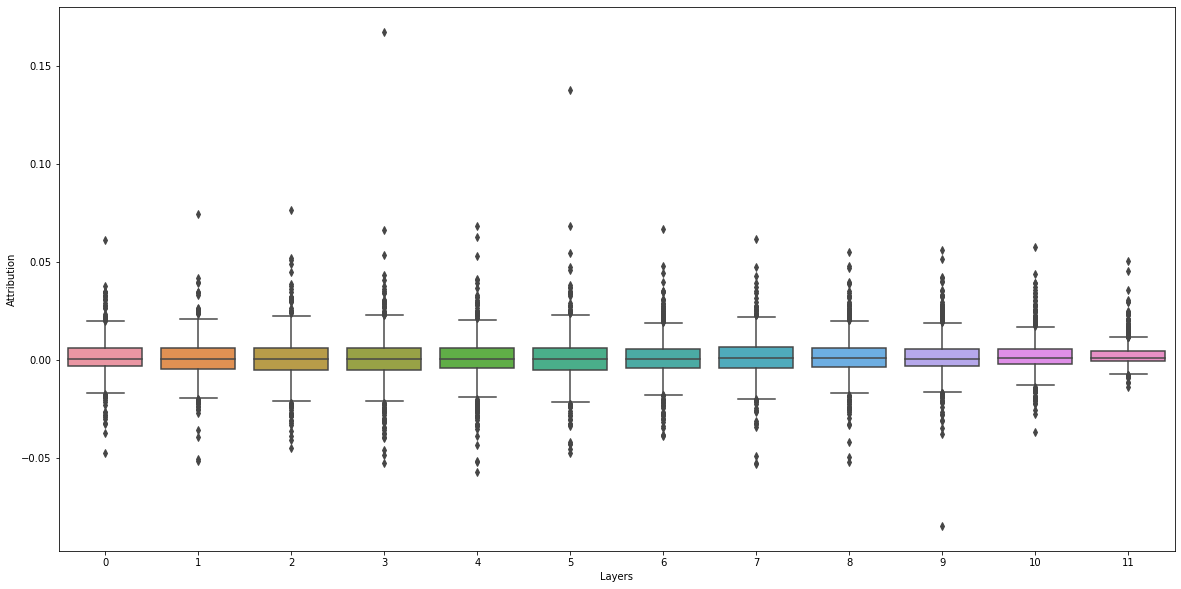

In [506]:
#plt.boxplot(layer_attrs_end_expanded.transpose()) #, positions=x, notch=True)
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.boxplot(data=layer_attrs_end_expanded[23])
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

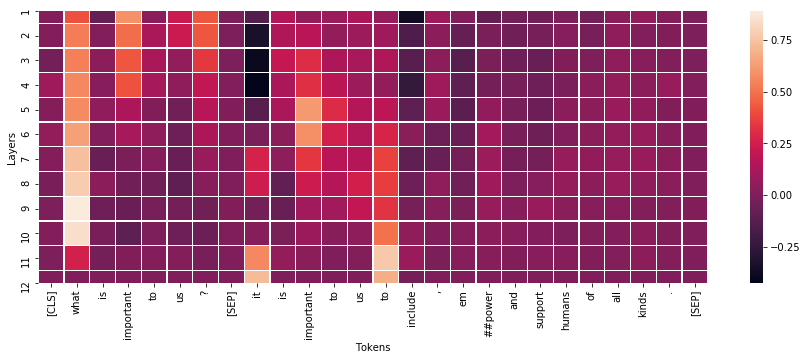

In [507]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=text
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_start, xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

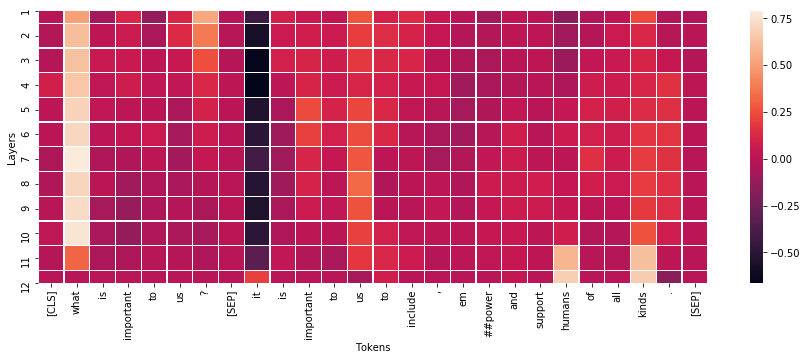

In [508]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=text
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_end, xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

In [509]:
remove_interpretable_embedding_layer(model, interpretable_embedding)

In [510]:
def pdf(numbers, n=5):
    maximum=max(numbers)
    minimum=min(numbers)
    total=len(numbers)

    range_=maximum - minimum

    step=range_/n
    bound=minimum
    countdict_pdf= {} # dictionary {bound : number of items between bound and bound+step}
    for i in range(0,n):
        countdict_pdf[bound]=sum(1 if (bound<x and x<=bound+step) else 0 for x in numbers) / total
        bound=bound+step
    ret = list(countdict_pdf.values())
    if len(ret) < n:
        ret.extend([0.0] * (n - len(ret)))
    return ret

In [511]:
atts1 = [pdf(layer_attr_end_expanded) for layer_attr_end_expanded in layer_attrs_end_expanded[1]]
atts2 = [pdf(layer_attr_end_expanded) for layer_attr_end_expanded in layer_attrs_end_expanded[23]]

attr1 = [sum(layer_attr_end_expanded) for layer_attr_end_expanded in layer_attrs_end_expanded[1]]
attr2 = [sum(layer_attr_end_expanded) for layer_attr_end_expanded in layer_attrs_end_expanded[23]]

atts1

[[0.0026041666666666665,
  0.028645833333333332,
  0.7213541666666666,
  0.234375,
  0.01171875],
 [0.0078125,
  0.041666666666666664,
  0.7630208333333334,
  0.1640625,
  0.022135416666666668],
 [0.010416666666666666,
  0.5716145833333334,
  0.3997395833333333,
  0.014322916666666666,
  0.0026041666666666665],
 [0.01171875,
  0.11848958333333333,
  0.7408854166666666,
  0.11848958333333333,
  0.009114583333333334],
 [0.0026041666666666665,
  0.061197916666666664,
  0.7278645833333334,
  0.18489583333333334,
  0.022135416666666668],
 [0.005208333333333333,
  0.28125,
  0.6432291666666666,
  0.05859375,
  0.009114583333333334],
 [0.040364583333333336,
  0.6809895833333334,
  0.2604166666666667,
  0.013020833333333334,
  0.00390625],
 [0.01953125, 0.21875, 0.6653645833333334, 0.08723958333333333, 0.0078125],
 [0.016927083333333332,
  0.7005208333333334,
  0.2669270833333333,
  0.013020833333333334,
  0.0013020833333333333],
 [0.044270833333333336,
  0.62109375,
  0.2916666666666667,
  0.

In [512]:
#atts1 = torch.exp(-torch.tensor(atts1))
#
#print(torch.tensor(atts2))
atts1 = torch.tensor(atts1)
atts1 = 0.9999 * atts1 + (0.0001 / atts1.shape[-1])
entropies1= -(atts1 * torch.log(atts1)).sum(-1)#.mean(-1)

#attns = 0.9999 * atts + (0.0001 / atts.shape[-1])
atts2 = torch.tensor(atts2) + 0.1e-15
print(atts2)
#atts2 = 0.9999 * atts2 + (0.0001 / atts2.shape[-1])
print(atts2)
entropies2= -(atts2 * torch.log(atts2)).sum(-1)#.mean(-1)
entropies2

tensor([[1.1719e-02, 2.0833e-01, 7.2526e-01, 5.2083e-02, 1.3021e-03],
        [5.2083e-03, 4.0755e-01, 5.6250e-01, 2.2135e-02, 1.3021e-03],
        [3.2552e-02, 6.1589e-01, 3.2682e-01, 2.2135e-02, 1.3021e-03],
        [1.4323e-01, 8.4635e-01, 7.8125e-03, 1.0000e-16, 1.3021e-03],
        [1.1719e-02, 1.5885e-01, 7.6953e-01, 5.4688e-02, 3.9062e-03],
        [1.1589e-01, 8.5807e-01, 2.2135e-02, 1.3021e-03, 1.3021e-03],
        [3.9062e-02, 6.3411e-01, 2.9818e-01, 2.4740e-02, 2.6042e-03],
        [9.1146e-03, 1.4453e-01, 7.7344e-01, 6.6406e-02, 5.2083e-03],
        [5.2083e-03, 9.5052e-02, 7.7865e-01, 1.0938e-01, 1.0417e-02],
        [1.0000e-16, 5.2083e-03, 4.2969e-01, 5.4297e-01, 2.0833e-02],
        [1.6927e-02, 4.6484e-01, 4.6745e-01, 4.4271e-02, 5.2083e-03],
        [1.8750e-01, 7.3698e-01, 6.5104e-02, 6.5104e-03, 2.6042e-03]])
tensor([[1.1719e-02, 2.0833e-01, 7.2526e-01, 5.2083e-02, 1.3021e-03],
        [5.2083e-03, 4.0755e-01, 5.6250e-01, 2.2135e-02, 1.3021e-03],
        [3.2552e-02

tensor([0.7744, 0.8098, 0.8685, 0.4661, 0.7265, 0.4827, 0.8834, 0.7286, 0.7355,
        0.8026, 0.9460, 0.7649])

tensor([0.7744, 0.8098, 0.8685, 0.4661, 0.7265, 0.4827, 0.8834, 0.7286, 0.7355,
        0.8026, 0.9460, 0.7649])


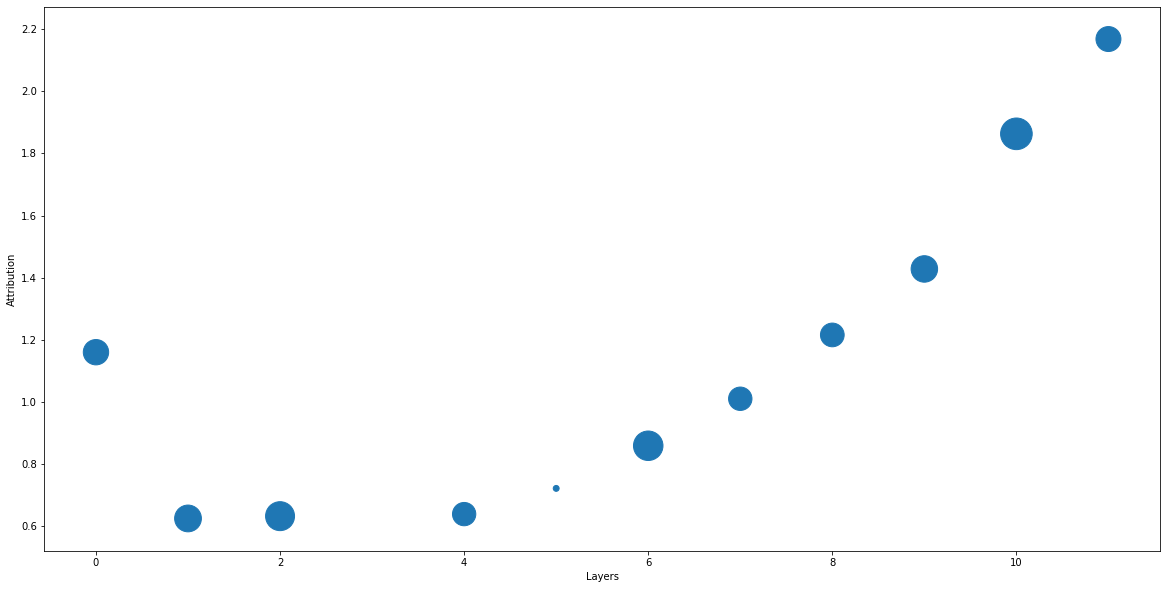

In [513]:
#plt.boxplot(layer_attrs_end_expanded.transpose()) #, positions=x, notch=True)
fig, ax = plt.subplots(figsize=(20,10))
#data = {'Attribution': atts1,
#        'c': np.arange(12),
#        'd': attr1}
norm = (entropies2 -  min(entropies2)) / (max(entropies2) - min(entropies2)) *1000
plt.scatter(np.arange(12), attr2, s=norm.tolist())
plt.xlabel('Layers')
plt.ylabel('Attribution')
#plt.show()
print(entropies2)

In [ ]:
area = (30 * np.random.rand(12))**2  # 0 to 15 point radii
area